## Predictive Model 

We use the Samsung health dataset to train and predict future walking/jogging distances of a given user. This will help inform whether the user is on track to meet their goal by a given time-frame. 

  

The predictive model is created using pyTorch.

In [180]:
# imports
import pandas as pd 
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.metrics import RMSE
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from sklearn.preprocessing import StandardScaler
plt.rcParams['figure.figsize'] = [12, 8]

In [158]:
# Feature engineering -- revisit to add features relating to special ocassions, i.e. new year 

data = pd.read_csv('Data/samsung_dataset.csv')

#data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')3
#data['month'] = data.date.dt.month.astype(str).astype('category')
#data["year"] = data.date.dt.year.astype(str).astype('category')
data['time_idx'] = data.index.values
data['group'] = 0
data.drop(['date'], axis=1, inplace=True)
data.head()

,com.samsung.health.heart_rate.heart_rate,run_step_count,walk_step_count,speed,distance,calorie,efficiency,time_idx,group
0,81.714286,9.0,971.0,1.726896,726.070,35.63,87.0,0,0
1,78.913043,53.0,1450.0,1.848388,1117.430,57.55,83.5,1,0
2,76.300000,13.0,2291.0,2.110930,1728.260,85.76,85.5,2,0
3,80.461538,64.0,3738.0,4.112905,2843.930,142.51,85.5,3,0
4,76.619048,186.0,5814.0,2.564951,4516.562,229.39,85.5,4,0


In [159]:
# Reshape data so that it is ready for pytorch 
nums = ['heart_rate', 'run_step_count', 'walk_step_count', 'speed', 'distance', 'calorie', 'efficiency']
data.columns = nums + ['time_idx', 'group']
#data = data.melt(id_vars=['date', 'time_idx'], var_name='feature', value_name='values')
#data['feature'] = data['feature'].astype('category')
#data.drop(['date'], axis=1, inplace=True)
#data.info()
#

In [193]:
# define pytorch TimeSeriesDataset
max_encoder_length = 7
max_prediction_length = 7
training_cutoff = 250  # day for cutoff
std = StandardScaler()
std.fit(data[nums][lambda x: x.index < training_cutoff])
data_nums = pd.DataFrame(std.transform(data[nums]), columns=nums)

data = pd.concat([data_nums, data[['time_idx', 'group']]], axis=1)
print(data.head())

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx < training_cutoff],
    time_idx= 'time_idx',
    target='distance',
    # weight="weight",
    group_ids=['group'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['run_step_count', 'walk_step_count', 'speed', 'distance', 'calorie', 'efficiency', 'heart_rate'],
    time_varying_known_reals=['time_idx']
)

   heart_rate  run_step_count  walk_step_count     speed  distance   calorie  \
0    0.934883       -1.017947        -1.928717 -0.164624 -1.922089 -1.964694   
1    0.132718        0.174706        -1.755946  0.028826 -1.731415 -1.756448   
2   -0.615554       -0.909524        -1.452604  0.446869 -1.433814 -1.488445   
3    0.576146        0.472869        -0.930684  3.634600 -0.890250 -0.949303   
4   -0.524191        3.779771        -0.181888  1.169804 -0.075331 -0.123918   

   efficiency  time_idx  group  
0    0.156332         0      0  
1   -0.881662         1      0  
2   -0.288523         2      0  
3   -0.288523         3      0  
4   -0.288523         4      0  


In [194]:
 # ------ Data Loaders ----------------
 # last max_prediction_length points in time for each series
 validation = TimeSeriesDataSet.from_dataset(
     training, data, predict=True, stop_randomization=True
 )
 # create dataloaders for model
 batch_size = 128
 train_dataloader = training.to_dataloader(
     train=True, batch_size=batch_size, num_workers=12
 )
 val_dataloader = validation.to_dataloader(
     train=False, batch_size=batch_size * 10, num_workers=12
 ) 

In [195]:
# calculate baseline mean absolute error, i.e. persistence forecast
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

2.9644954204559326

In [196]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42


GPU available: False, used: False


TPU available: None, using: 0 TPU cores


Number of parameters in network: 20.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 144   
4  | static_variable_selection          | VariableSelectionNetwork        | 528   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Finding best initial lr:   2%|▏         | 2/100 [00:00<00:09, 10.84it/s]

Finding best initial lr:   4%|▍         | 4/100 [00:00<00:19,  4.96it/s]

Finding best initial lr:   5%|▌         | 5/100 [00:01<00:25,  3.77it/s]

Finding best initial lr:   6%|▌         | 6/100 [00:01<00:20,  4.63it/s]

Finding best initial lr:   7%|▋         | 7/100 [00:01<00:26,  3.46it/s]

Finding best initial lr:   8%|▊         | 8/100 [00:01<00:21,  4.22it/s]

Finding best initial lr:   9%|▉         | 9/100 [00:02<00:28,  3.25it/s]

Finding best initial lr:  10%|█         | 10/100 [00:02<00:22,  4.03it/s]

Finding best initial lr:  11%|█         | 11/100 [00:02<00:29,  2.99it/s]

Finding best initial lr:  12%|█▏        | 12/100 [00:03<00:23,  3.72it/s]

Finding best initial lr:  13%|█▎        | 13/100 [00:03<00:28,  3.00it/s]

Finding best initial lr:  15%|█▌        | 15/100 [00:04<00:25,  3.31it/s]

Finding best initial lr:  17%|█▋        | 17/100 [00:04<00:24,  3.33it/s]

Finding best initial lr:  18%|█▊        | 18/100 [00:04<00:21,  3.88it/s]

Finding best initial lr:  19%|█▉        | 19/100 [00:05<00:23,  3.44it/s]

Finding best initial lr:  21%|██        | 21/100 [00:05<00:20,  3.77it/s]

Finding best initial lr:  23%|██▎       | 23/100 [00:06<00:19,  4.00it/s]

Finding best initial lr:  25%|██▌       | 25/100 [00:06<00:17,  4.20it/s]

Finding best initial lr:  27%|██▋       | 27/100 [00:06<00:17,  4.24it/s]

Finding best initial lr:  28%|██▊       | 28/100 [00:07<00:15,  4.70it/s]

Finding best initial lr:  29%|██▉       | 29/100 [00:07<00:18,  3.94it/s]

Finding best initial lr:  31%|███       | 31/100 [00:07<00:17,  4.01it/s]

Finding best initial lr:  33%|███▎      | 33/100 [00:08<00:16,  4.11it/s]

Finding best initial lr:  35%|███▌      | 35/100 [00:08<00:15,  4.20it/s]

Finding best initial lr:  37%|███▋      | 37/100 [00:09<00:14,  4.28it/s]

Finding best initial lr:  39%|███▉      | 39/100 [00:09<00:13,  4.38it/s]

Finding best initial lr:  41%|████      | 41/100 [00:10<00:13,  4.35it/s]

Finding best initial lr:  43%|████▎     | 43/100 [00:10<00:12,  4.38it/s]

Finding best initial lr:  45%|████▌     | 45/100 [00:11<00:12,  4.43it/s]

Finding best initial lr:  47%|████▋     | 47/100 [00:11<00:11,  4.45it/s]

Finding best initial lr:  49%|████▉     | 49/100 [00:12<00:11,  4.37it/s]

Finding best initial lr:  51%|█████     | 51/100 [00:12<00:11,  4.38it/s]

Finding best initial lr:  53%|█████▎    | 53/100 [00:12<00:10,  4.42it/s]

Finding best initial lr:  55%|█████▌    | 55/100 [00:13<00:10,  4.46it/s]

Finding best initial lr:  57%|█████▋    | 57/100 [00:13<00:09,  4.41it/s]

Finding best initial lr:  59%|█████▉    | 59/100 [00:14<00:09,  4.34it/s]

Finding best initial lr:  61%|██████    | 61/100 [00:14<00:08,  4.37it/s]

Finding best initial lr:  63%|██████▎   | 63/100 [00:15<00:08,  4.34it/s]

Finding best initial lr:  65%|██████▌   | 65/100 [00:15<00:07,  4.41it/s]

Finding best initial lr:  67%|██████▋   | 67/100 [00:16<00:07,  4.46it/s]

Finding best initial lr:  69%|██████▉   | 69/100 [00:16<00:06,  4.48it/s]

Finding best initial lr:  71%|███████   | 71/100 [00:17<00:06,  4.51it/s]

Finding best initial lr:  73%|███████▎  | 73/100 [00:17<00:05,  4.53it/s]

Finding best initial lr:  75%|███████▌  | 75/100 [00:17<00:05,  4.56it/s]

Finding best initial lr:  77%|███████▋  | 77/100 [00:18<00:05,  4.57it/s]

Finding best initial lr:  79%|███████▉  | 79/100 [00:18<00:04,  4.57it/s]

Finding best initial lr:  81%|████████  | 81/100 [00:19<00:04,  4.58it/s]

Finding best initial lr:  83%|████████▎ | 83/100 [00:19<00:03,  4.57it/s]

Finding best initial lr:  85%|████████▌ | 85/100 [00:20<00:03,  4.54it/s]

Finding best initial lr:  87%|████████▋ | 87/100 [00:20<00:02,  4.56it/s]

Finding best initial lr:  89%|████████▉ | 89/100 [00:20<00:02,  4.56it/s]

Finding best initial lr:  91%|█████████ | 91/100 [00:21<00:01,  4.56it/s]

Finding best initial lr:  93%|█████████▎| 93/100 [00:21<00:01,  4.54it/s]

Finding best initial lr:  95%|█████████▌| 95/100 [00:22<00:01,  4.48it/s]

Finding best initial lr:  97%|█████████▋| 97/100 [00:22<00:00,  4.47it/s]

Finding best initial lr:  99%|█████████▉| 99/100 [00:23<00:00,  4.49it/s]

Restored states from the checkpoint file at /Users/aayush/Documents/Run4It/Run4It/Model/lr_find_temp_model.ckpt


suggested learning rate: 0.07943282347242808


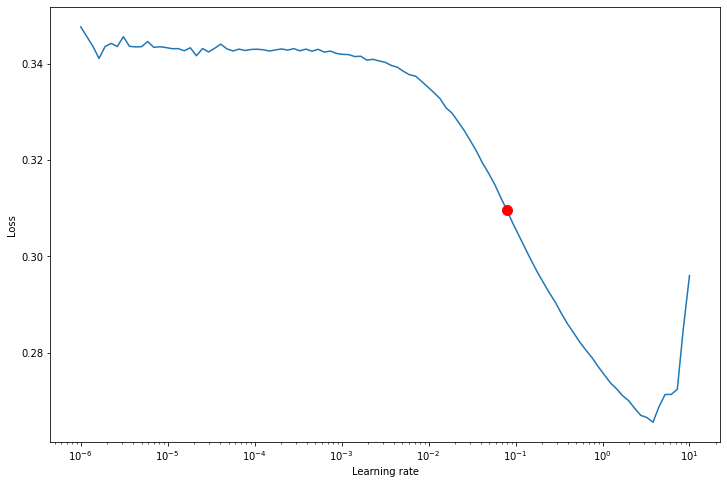

/Users/aayush/azuredatastudio-python/0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


In [197]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [199]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.08,
    hidden_size=128,
    attention_head_size=16,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False


TPU available: None, using: 0 TPU cores


Number of parameters in network: 847.0k


In [190]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 48    
4  | static_variable_selection          | VariableSelectionNetwork        | 3.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 66.3 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 66.3 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 66.3

Validation sanity check: 0it [00:00, ?it/s]

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

Validation sanity check: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

Training: 0it [00:00, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s] 

Epoch 0:  33%|███▎      | 1/3 [00:00<00:01,  1.64it/s]

Epoch 0:  33%|███▎      | 1/3 [00:00<00:01,  1.63it/s, loss=0.441, v_num=10, val_loss=0.269]

Epoch 0:  67%|██████▋   | 2/3 [00:00<00:00,  2.40it/s, loss=0.441, v_num=10, val_loss=0.269]

Epoch 0:  67%|██████▋   | 2/3 [00:00<00:00,  2.40it/s, loss=0.429, v_num=10, val_loss=0.269, train_loss_step=0.441]

Epoch 0: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, loss=0.429, v_num=10, val_loss=0.269, train_loss_step=0.441]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

Epoch 0: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s, loss=0.429, v_num=10, val_loss=0.252, train_loss_step=0.417, train_loss_epoch=0.429]

Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.429, v_num=10, val_loss=0.252, train_loss_step=0.417, train_loss_epoch=0.429]        

Epoch 1:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.429, v_num=10, val_loss=0.252, train_loss_step=0.417, train_loss_epoch=0.429]

Epoch 1:  33%|███▎      | 1/3 [00:00<00:01,  1.50it/s, loss=0.429, v_num=10, val_loss=0.252, train_loss_step=0.417, train_loss_epoch=0.429]

Epoch 1:  33%|███▎      | 1/3 [00:00<00:01,  1.50it/s, loss=0.418, v_num=10, val_loss=0.252, train_loss_step=0.417, train_loss_epoch=0.429]

Epoch 1:  67%|██████▋   | 2/3 [00:00<00:00,  2.27it/s, loss=0.418, v_num=10, val_loss=0.252, train_loss_step=0.417, train_loss_epoch=0.429]

Epoch 1:  67%|██████▋   | 2/3 [00:00<00:00,  2.27it/s, loss=0.417, v_num=10, val_loss=0.252, train_loss_step=0.397, train_loss_epoch=0.429]

Epoch 1: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=0.417, v_num=10, val_loss=0.252, train_loss_step=0.397, train_loss_epoch=0.429]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

Epoch 1: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=0.417, v_num=10, val_loss=0.237, train_loss_step=0.414, train_loss_epoch=0.405]

Epoch 1:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.417, v_num=10, val_loss=0.237, train_loss_step=0.414, train_loss_epoch=0.405]        

Epoch 2:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.417, v_num=10, val_loss=0.237, train_loss_step=0.414, train_loss_epoch=0.405]

Epoch 2:  33%|███▎      | 1/3 [00:00<00:01,  1.44it/s, loss=0.417, v_num=10, val_loss=0.237, train_loss_step=0.414, train_loss_epoch=0.405]

Epoch 2:  33%|███▎      | 1/3 [00:00<00:01,  1.43it/s, loss=0.411, v_num=10, val_loss=0.237, train_loss_step=0.414, train_loss_epoch=0.405]

Epoch 2:  67%|██████▋   | 2/3 [00:00<00:00,  2.20it/s, loss=0.411, v_num=10, val_loss=0.237, train_loss_step=0.414, train_loss_epoch=0.405]

Epoch 2:  67%|██████▋   | 2/3 [00:00<00:00,  2.20it/s, loss=0.408, v_num=10, val_loss=0.237, train_loss_step=0.384, train_loss_epoch=0.405]

Epoch 2: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s, loss=0.408, v_num=10, val_loss=0.237, train_loss_step=0.384, train_loss_epoch=0.405]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

Epoch 2: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s, loss=0.408, v_num=10, val_loss=0.188, train_loss_step=0.394, train_loss_epoch=0.389]

Epoch 2:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.408, v_num=10, val_loss=0.188, train_loss_step=0.394, train_loss_epoch=0.389]        

Epoch 3:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.408, v_num=10, val_loss=0.188, train_loss_step=0.394, train_loss_epoch=0.389]

Epoch 3:  33%|███▎      | 1/3 [00:00<00:01,  1.38it/s, loss=0.408, v_num=10, val_loss=0.188, train_loss_step=0.394, train_loss_epoch=0.389]

Epoch 3:  33%|███▎      | 1/3 [00:00<00:01,  1.38it/s, loss=0.399, v_num=10, val_loss=0.188, train_loss_step=0.394, train_loss_epoch=0.389]

Epoch 3:  67%|██████▋   | 2/3 [00:00<00:00,  2.14it/s, loss=0.399, v_num=10, val_loss=0.188, train_loss_step=0.394, train_loss_epoch=0.389]

Epoch 3:  67%|██████▋   | 2/3 [00:00<00:00,  2.13it/s, loss=0.377, v_num=10, val_loss=0.188, train_loss_step=0.342, train_loss_epoch=0.389]

Epoch 3: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s, loss=0.377, v_num=10, val_loss=0.188, train_loss_step=0.342, train_loss_epoch=0.389]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

Epoch 3: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=0.377, v_num=10, val_loss=0.138, train_loss_step=0.230, train_loss_epoch=0.286]

Epoch 3:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.377, v_num=10, val_loss=0.138, train_loss_step=0.230, train_loss_epoch=0.286]        

Epoch 4:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.377, v_num=10, val_loss=0.138, train_loss_step=0.230, train_loss_epoch=0.286]

Epoch 4:  33%|███▎      | 1/3 [00:01<00:03,  1.95s/it, loss=0.377, v_num=10, val_loss=0.138, train_loss_step=0.230, train_loss_epoch=0.286]

Epoch 4:  33%|███▎      | 1/3 [00:01<00:03,  1.96s/it, loss=0.359, v_num=10, val_loss=0.138, train_loss_step=0.230, train_loss_epoch=0.286]

Epoch 4:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it, loss=0.359, v_num=10, val_loss=0.138, train_loss_step=0.230, train_loss_epoch=0.286]

Epoch 4:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it, loss=0.344, v_num=10, val_loss=0.138, train_loss_step=0.214, train_loss_epoch=0.286]

Epoch 4: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s, loss=0.344, v_num=10, val_loss=0.138, train_loss_step=0.214, train_loss_epoch=0.286]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

Epoch 4: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it, loss=0.344, v_num=10, val_loss=0.126, train_loss_step=0.211, train_loss_epoch=0.212]

Epoch 4:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.344, v_num=10, val_loss=0.126, train_loss_step=0.211, train_loss_epoch=0.212]        

Epoch 5:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.344, v_num=10, val_loss=0.126, train_loss_step=0.211, train_loss_epoch=0.212]

Epoch 5:  33%|███▎      | 1/3 [00:00<00:01,  1.72it/s, loss=0.344, v_num=10, val_loss=0.126, train_loss_step=0.211, train_loss_epoch=0.212]

Epoch 5:  33%|███▎      | 1/3 [00:00<00:01,  1.71it/s, loss=0.332, v_num=10, val_loss=0.126, train_loss_step=0.211, train_loss_epoch=0.212]

Epoch 5:  67%|██████▋   | 2/3 [00:00<00:00,  2.49it/s, loss=0.332, v_num=10, val_loss=0.126, train_loss_step=0.211, train_loss_epoch=0.212]

Epoch 5:  67%|██████▋   | 2/3 [00:00<00:00,  2.49it/s, loss=0.321, v_num=10, val_loss=0.126, train_loss_step=0.206, train_loss_epoch=0.212]

Epoch 5: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s, loss=0.321, v_num=10, val_loss=0.126, train_loss_step=0.206, train_loss_epoch=0.212]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

Epoch 5: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s, loss=0.321, v_num=10, val_loss=0.122, train_loss_step=0.207, train_loss_epoch=0.207]

Epoch 5:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.321, v_num=10, val_loss=0.122, train_loss_step=0.207, train_loss_epoch=0.207]        

Epoch 6:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.321, v_num=10, val_loss=0.122, train_loss_step=0.207, train_loss_epoch=0.207]

Epoch 6:  33%|███▎      | 1/3 [00:00<00:01,  1.58it/s, loss=0.321, v_num=10, val_loss=0.122, train_loss_step=0.207, train_loss_epoch=0.207]

Epoch 6:  33%|███▎      | 1/3 [00:00<00:01,  1.57it/s, loss=0.312, v_num=10, val_loss=0.122, train_loss_step=0.207, train_loss_epoch=0.207]

Epoch 6:  67%|██████▋   | 2/3 [00:00<00:00,  2.32it/s, loss=0.312, v_num=10, val_loss=0.122, train_loss_step=0.207, train_loss_epoch=0.207]

Epoch 6:  67%|██████▋   | 2/3 [00:00<00:00,  2.32it/s, loss=0.304, v_num=10, val_loss=0.122, train_loss_step=0.204, train_loss_epoch=0.207]

Epoch 6: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.304, v_num=10, val_loss=0.122, train_loss_step=0.204, train_loss_epoch=0.207]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

Epoch 6: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s, loss=0.304, v_num=10, val_loss=0.131, train_loss_step=0.193, train_loss_epoch=0.199]

Epoch 6:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.304, v_num=10, val_loss=0.131, train_loss_step=0.193, train_loss_epoch=0.199]        

Epoch 7:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.304, v_num=10, val_loss=0.131, train_loss_step=0.193, train_loss_epoch=0.199]

Epoch 7:  33%|███▎      | 1/3 [00:00<00:01,  1.52it/s, loss=0.304, v_num=10, val_loss=0.131, train_loss_step=0.193, train_loss_epoch=0.199]

Epoch 7:  33%|███▎      | 1/3 [00:00<00:01,  1.52it/s, loss=0.296, v_num=10, val_loss=0.131, train_loss_step=0.193, train_loss_epoch=0.199]

Epoch 7:  67%|██████▋   | 2/3 [00:00<00:00,  2.30it/s, loss=0.296, v_num=10, val_loss=0.131, train_loss_step=0.193, train_loss_epoch=0.199]

Epoch 7:  67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s, loss=0.289, v_num=10, val_loss=0.131, train_loss_step=0.185, train_loss_epoch=0.199]

Epoch 7: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=0.289, v_num=10, val_loss=0.131, train_loss_step=0.185, train_loss_epoch=0.199]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

Epoch 7: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s, loss=0.289, v_num=10, val_loss=0.192, train_loss_step=0.190, train_loss_epoch=0.187]

Epoch 7:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.289, v_num=10, val_loss=0.192, train_loss_step=0.190, train_loss_epoch=0.187]        

Epoch 8:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.289, v_num=10, val_loss=0.192, train_loss_step=0.190, train_loss_epoch=0.187]

Epoch 8:  33%|███▎      | 1/3 [00:00<00:01,  1.30it/s, loss=0.289, v_num=10, val_loss=0.192, train_loss_step=0.190, train_loss_epoch=0.187]

Epoch 8:  33%|███▎      | 1/3 [00:00<00:01,  1.29it/s, loss=0.283, v_num=10, val_loss=0.192, train_loss_step=0.190, train_loss_epoch=0.187]

Epoch 8:  67%|██████▋   | 2/3 [00:01<00:00,  1.95it/s, loss=0.283, v_num=10, val_loss=0.192, train_loss_step=0.190, train_loss_epoch=0.187]

Epoch 8:  67%|██████▋   | 2/3 [00:01<00:00,  1.95it/s, loss=0.278, v_num=10, val_loss=0.192, train_loss_step=0.184, train_loss_epoch=0.187]

Epoch 8: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s, loss=0.278, v_num=10, val_loss=0.192, train_loss_step=0.184, train_loss_epoch=0.187]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Epoch 8: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s, loss=0.278, v_num=10, val_loss=0.139, train_loss_step=0.196, train_loss_epoch=0.190]

Epoch 8:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.278, v_num=10, val_loss=0.139, train_loss_step=0.196, train_loss_epoch=0.190]        

Epoch 9:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.278, v_num=10, val_loss=0.139, train_loss_step=0.196, train_loss_epoch=0.190]

Epoch 9:  33%|███▎      | 1/3 [00:00<00:01,  1.51it/s, loss=0.278, v_num=10, val_loss=0.139, train_loss_step=0.196, train_loss_epoch=0.190]

Epoch 9:  33%|███▎      | 1/3 [00:00<00:01,  1.51it/s, loss=0.273, v_num=10, val_loss=0.139, train_loss_step=0.196, train_loss_epoch=0.190]

Epoch 9:  67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s, loss=0.273, v_num=10, val_loss=0.139, train_loss_step=0.196, train_loss_epoch=0.190]

Epoch 9:  67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s, loss=0.269, v_num=10, val_loss=0.139, train_loss_step=0.180, train_loss_epoch=0.190]

Epoch 9: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s, loss=0.269, v_num=10, val_loss=0.139, train_loss_step=0.180, train_loss_epoch=0.190]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

Epoch 9: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s, loss=0.269, v_num=10, val_loss=0.180, train_loss_step=0.182, train_loss_epoch=0.181]

Epoch 9:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.269, v_num=10, val_loss=0.180, train_loss_step=0.182, train_loss_epoch=0.181]        

Epoch 10:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.269, v_num=10, val_loss=0.180, train_loss_step=0.182, train_loss_epoch=0.181]

Epoch 10:  33%|███▎      | 1/3 [00:00<00:01,  1.44it/s, loss=0.269, v_num=10, val_loss=0.180, train_loss_step=0.182, train_loss_epoch=0.181]

Epoch 10:  33%|███▎      | 1/3 [00:00<00:01,  1.43it/s, loss=0.256, v_num=10, val_loss=0.180, train_loss_step=0.182, train_loss_epoch=0.181]

Epoch 10:  67%|██████▋   | 2/3 [00:00<00:00,  2.21it/s, loss=0.256, v_num=10, val_loss=0.180, train_loss_step=0.182, train_loss_epoch=0.181]

Epoch 10:  67%|██████▋   | 2/3 [00:00<00:00,  2.21it/s, loss=0.244, v_num=10, val_loss=0.180, train_loss_step=0.181, train_loss_epoch=0.181]

Epoch 10: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=0.244, v_num=10, val_loss=0.180, train_loss_step=0.181, train_loss_epoch=0.181]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

Epoch 10: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=0.244, v_num=10, val_loss=0.161, train_loss_step=0.180, train_loss_epoch=0.180]

Epoch 10:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.244, v_num=10, val_loss=0.161, train_loss_step=0.180, train_loss_epoch=0.180]        

Epoch 11:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.244, v_num=10, val_loss=0.161, train_loss_step=0.180, train_loss_epoch=0.180]

Epoch 11:  33%|███▎      | 1/3 [00:00<00:01,  1.51it/s, loss=0.244, v_num=10, val_loss=0.161, train_loss_step=0.180, train_loss_epoch=0.180]

Epoch 11:  33%|███▎      | 1/3 [00:00<00:01,  1.51it/s, loss=0.233, v_num=10, val_loss=0.161, train_loss_step=0.180, train_loss_epoch=0.180]

Epoch 11:  67%|██████▋   | 2/3 [00:00<00:00,  2.27it/s, loss=0.233, v_num=10, val_loss=0.161, train_loss_step=0.180, train_loss_epoch=0.180]

Epoch 11:  67%|██████▋   | 2/3 [00:00<00:00,  2.27it/s, loss=0.221, v_num=10, val_loss=0.161, train_loss_step=0.177, train_loss_epoch=0.180]

Epoch 11: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s, loss=0.221, v_num=10, val_loss=0.161, train_loss_step=0.177, train_loss_epoch=0.180]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

Epoch 11: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=0.221, v_num=10, val_loss=0.152, train_loss_step=0.186, train_loss_epoch=0.182]

Epoch 11:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.221, v_num=10, val_loss=0.152, train_loss_step=0.186, train_loss_epoch=0.182]        

Epoch 12:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.221, v_num=10, val_loss=0.152, train_loss_step=0.186, train_loss_epoch=0.182]

Epoch 12:  33%|███▎      | 1/3 [00:00<00:01,  1.78it/s, loss=0.221, v_num=10, val_loss=0.152, train_loss_step=0.186, train_loss_epoch=0.182]

Epoch 12:  33%|███▎      | 1/3 [00:00<00:01,  1.78it/s, loss=0.211, v_num=10, val_loss=0.152, train_loss_step=0.186, train_loss_epoch=0.182]

Epoch 12:  67%|██████▋   | 2/3 [00:00<00:00,  2.61it/s, loss=0.211, v_num=10, val_loss=0.152, train_loss_step=0.186, train_loss_epoch=0.182]

Epoch 12:  67%|██████▋   | 2/3 [00:00<00:00,  2.61it/s, loss=0.2, v_num=10, val_loss=0.152, train_loss_step=0.175, train_loss_epoch=0.182]  

Epoch 12: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s, loss=0.2, v_num=10, val_loss=0.152, train_loss_step=0.175, train_loss_epoch=0.182]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

Epoch 12: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s, loss=0.2, v_num=10, val_loss=0.160, train_loss_step=0.174, train_loss_epoch=0.175]

Epoch 12:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.2, v_num=10, val_loss=0.160, train_loss_step=0.174, train_loss_epoch=0.175]        

Epoch 13:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.2, v_num=10, val_loss=0.160, train_loss_step=0.174, train_loss_epoch=0.175]

Epoch 13:  33%|███▎      | 1/3 [00:00<00:01,  1.39it/s, loss=0.2, v_num=10, val_loss=0.160, train_loss_step=0.174, train_loss_epoch=0.175]

Epoch 13:  33%|███▎      | 1/3 [00:00<00:01,  1.39it/s, loss=0.191, v_num=10, val_loss=0.160, train_loss_step=0.174, train_loss_epoch=0.175]

Epoch 13:  67%|██████▋   | 2/3 [00:00<00:00,  2.17it/s, loss=0.191, v_num=10, val_loss=0.160, train_loss_step=0.174, train_loss_epoch=0.175]

Epoch 13:  67%|██████▋   | 2/3 [00:00<00:00,  2.17it/s, loss=0.189, v_num=10, val_loss=0.160, train_loss_step=0.174, train_loss_epoch=0.175]

Epoch 13: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s, loss=0.189, v_num=10, val_loss=0.160, train_loss_step=0.174, train_loss_epoch=0.175]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

Epoch 13: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s, loss=0.189, v_num=10, val_loss=0.159, train_loss_step=0.175, train_loss_epoch=0.174]

Epoch 13:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.189, v_num=10, val_loss=0.159, train_loss_step=0.175, train_loss_epoch=0.174]        

Epoch 14:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.189, v_num=10, val_loss=0.159, train_loss_step=0.175, train_loss_epoch=0.174]

Epoch 14:  33%|███▎      | 1/3 [00:00<00:01,  1.62it/s, loss=0.189, v_num=10, val_loss=0.159, train_loss_step=0.175, train_loss_epoch=0.174]

Epoch 14:  33%|███▎      | 1/3 [00:00<00:01,  1.62it/s, loss=0.187, v_num=10, val_loss=0.159, train_loss_step=0.175, train_loss_epoch=0.174]

Epoch 14:  67%|██████▋   | 2/3 [00:00<00:00,  2.38it/s, loss=0.187, v_num=10, val_loss=0.159, train_loss_step=0.175, train_loss_epoch=0.174]

Epoch 14:  67%|██████▋   | 2/3 [00:00<00:00,  2.38it/s, loss=0.185, v_num=10, val_loss=0.159, train_loss_step=0.175, train_loss_epoch=0.174]

Epoch 14: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s, loss=0.185, v_num=10, val_loss=0.159, train_loss_step=0.175, train_loss_epoch=0.174]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

Epoch 14: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s, loss=0.185, v_num=10, val_loss=0.152, train_loss_step=0.173, train_loss_epoch=0.174]

Epoch 14:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.185, v_num=10, val_loss=0.152, train_loss_step=0.173, train_loss_epoch=0.174]        

Epoch 15:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.185, v_num=10, val_loss=0.152, train_loss_step=0.173, train_loss_epoch=0.174]

Epoch 15:  33%|███▎      | 1/3 [00:00<00:01,  1.51it/s, loss=0.185, v_num=10, val_loss=0.152, train_loss_step=0.173, train_loss_epoch=0.174]

Epoch 15:  33%|███▎      | 1/3 [00:00<00:01,  1.51it/s, loss=0.183, v_num=10, val_loss=0.152, train_loss_step=0.173, train_loss_epoch=0.174]

Epoch 15:  67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s, loss=0.183, v_num=10, val_loss=0.152, train_loss_step=0.173, train_loss_epoch=0.174]

Epoch 15:  67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s, loss=0.182, v_num=10, val_loss=0.152, train_loss_step=0.170, train_loss_epoch=0.174]

Epoch 15: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s, loss=0.182, v_num=10, val_loss=0.152, train_loss_step=0.170, train_loss_epoch=0.174]

Validating: 0it [00:00, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

Epoch 15: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s, loss=0.182, v_num=10, val_loss=0.150, train_loss_step=0.177, train_loss_epoch=0.173]

Epoch 15: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s, loss=0.182, v_num=10, val_loss=0.150, train_loss_step=0.177, train_loss_epoch=0.173]

1

In [198]:
# Best performing model 
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

IsADirectoryError: [Errno 21] Is a directory: '/Users/aayush/Documents/Run4It/Run4It/Model'

In [187]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

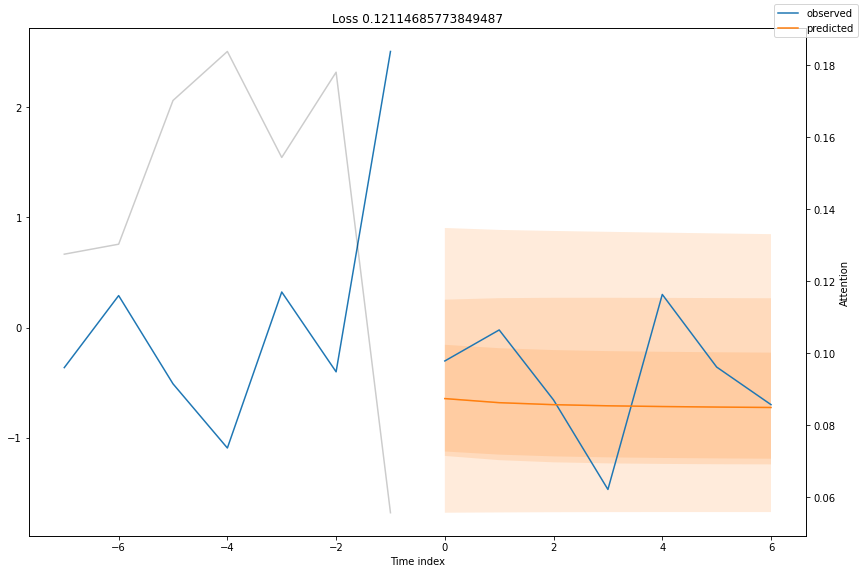

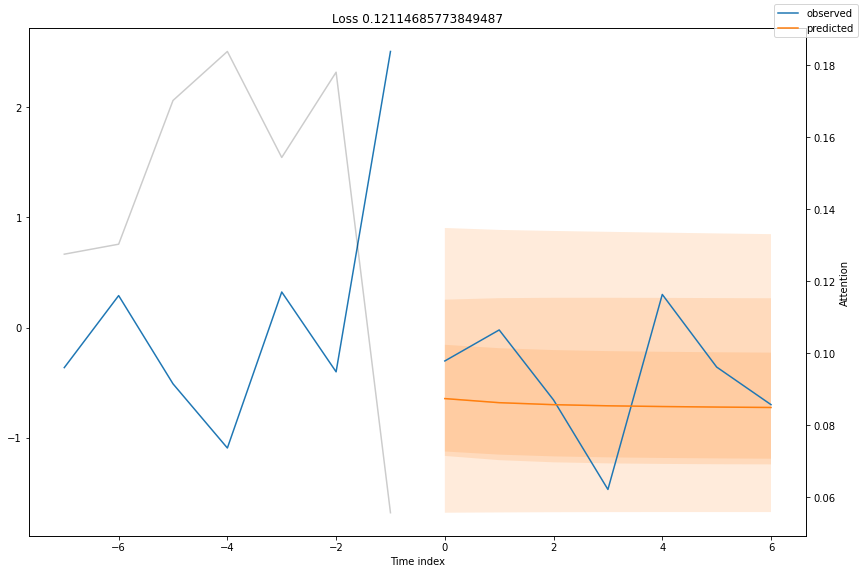

In [188]:
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)